Import relevant packages 

In [239]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast

# Table of Contents
* [Preprocessing data](#chapter1)
    * [Cleaning data](#cleaning_section)
    * [Products distribution](#distribution_section)
    * [Textual data](#text_section)
    * [Merging the data](#merge_section)

Use pandas to read the csv files for the webscraped data for both the product_id and price and the description

In [240]:
df_products = pd.read_csv('data/df_Salling_Products.csv' , delimiter=";")   # Read the csv file containing the products_id
df_text = pd.read_csv('data/df_Salling_Products_Descriptions.csv' , delimiter=";")  # Read the csv file containing the descriptions
df_neighbours = pd.read_csv('data/df_Salling_Products_Neighbours.csv', delimiter=";")   # Read the csv file containing the neighbours to a specific product_id

## Preprocess the data <a class="anchor" id="chapter1">

In this section we filter and clean data such that we can control which parameters and categories we are interested to work with

### Cleaning data <a id="cleaning_section">

In [241]:
# Cleaning data here:

df_products[['price_amount', 'unit']] = df_products['price'].str.split('/', expand=True)    # Cleaning price attribute
df_products['price_amount'] = df_products['price_amount'].str.replace(',', '.').str.extract('(\d+.\d+)').astype(float)  # Cleaning price attribute

df_products['category'] = df_products['category'].str.replace('/','')     # Cleaning category attribute 
df_products.drop(columns=['Unnamed: 0'], inplace=True)    # Drop the original price column

df_products.head()

,product_id,name,price,link,category,price_amount,unit
0,18381,Bananer,"2,75/Stk.",/produkt/bananer/18381/,frugt-og-groent,2.75,Stk.
1,51061,Peberfrugter røde,"7,25/Stk.",/produkt/peberfrugter-roede/51061/,frugt-og-groent,7.25,Stk.
2,61090,Agurk øko,"9,00/Stk.",/produkt/salling-oeko-agurk-oeko/61090/,frugt-og-groent,9.00,Stk.
3,72008,Bananer 4 pak øko,"2,20/Stk.",/produkt/bananer-4-pak-oeko/72008/,frugt-og-groent,2.20,Stk.
4,18323,Gulerødder,"10,00/Kg.",/produkt/salling-guleroedder/18323/,frugt-og-groent,10.00,Kg.


converting the lists to lists and not strings

In [242]:
def convert_string_to_list(string_list):
    return ast.literal_eval(string_list) 


df_neighbours['neighbor_products_id'] = df_neighbours['neighbor_products_id'].apply(convert_string_to_list)

Distribute the 21 different inner categories into 3 main categories:

In [243]:
foods = ['frugt-og-groent', 'koed-og-fisk', 'mejeri-og-koel', 'drikkevarer', 'broed-og-kager','kolonial', 'slik-og-snacks', 'frost']
house = ['husholdning', 'personlig-pleje', 'baby-og-boern', 'bolig-og-koekken', 'fritid-og-sport', 'toej-og-sko', 'have', 'leg', 'byggemarked']
other = ['dyremad','elektronik','biludstyr', 'kiosk']

df_products['outer_category'] = df_products['category'].map(lambda x: 'Foods' if x in foods else ('House' if x in house else 'Other'))

df_products.head()

,product_id,name,price,link,category,price_amount,unit,outer_category
0,18381,Bananer,"2,75/Stk.",/produkt/bananer/18381/,frugt-og-groent,2.75,Stk.,Foods
1,51061,Peberfrugter røde,"7,25/Stk.",/produkt/peberfrugter-roede/51061/,frugt-og-groent,7.25,Stk.,Foods
2,61090,Agurk øko,"9,00/Stk.",/produkt/salling-oeko-agurk-oeko/61090/,frugt-og-groent,9.00,Stk.,Foods
3,72008,Bananer 4 pak øko,"2,20/Stk.",/produkt/bananer-4-pak-oeko/72008/,frugt-og-groent,2.20,Stk.,Foods
4,18323,Gulerødder,"10,00/Kg.",/produkt/salling-guleroedder/18323/,frugt-og-groent,10.00,Kg.,Foods


### Distribution of the categories of the webscraped products from the [BilkaToGO](https://www.bilkatogo.dk/) website <a id="distribution_section"></a>

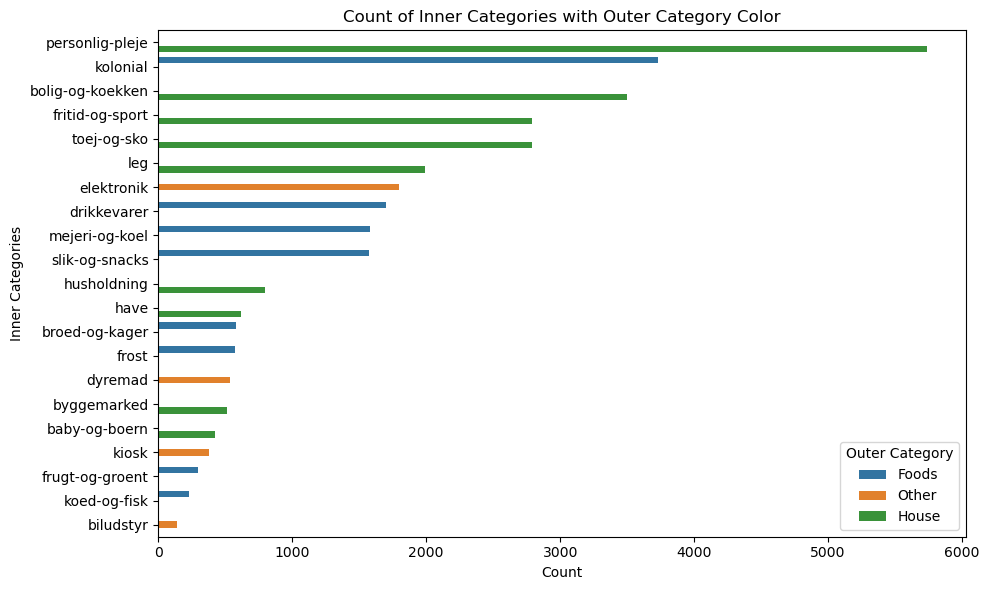

outer_category
House    19163
Foods    10269
Other     2853
Name: count, dtype: int64

In [244]:
plt.figure(figsize=(10, 6))
sns.countplot(y='category', data=df_products, hue='outer_category', order=df_products['category'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Inner Categories')
plt.title('Count of Inner Categories with Outer Category Color')
plt.legend(title='Outer Category')
plt.tight_layout()
plt.show()

df_products['outer_category'].value_counts()

The plot shows the distribution of products across the different categories. The categories are divided into 3 main categories: 'Food', 'House' and 'Other'. The Food category contains 10.269 products, the House category contains 19.163 products and the Other category contains 2.853 products.

In this project we will be focusing on the Food category.

### Textual data <a id="text_section">

In [245]:
df_text = df_text.rename(columns = {'p_id':'product_id'})
no_description = df_text[df_text['descriptions'].isnull()]['descriptions'].value_counts()   # Check for null values

print(f"There are {no_description.sum()} null values in the dataset")

There are 0 null values in the dataset


Removing extra description that were collected in the webscraping that is not about the product itself

In [246]:
df_text['descriptions'] = df_text['descriptions'].str.lower().str.split('om salling').str[0].str.strip()
df_text['descriptions'] = df_text['descriptions'].str.lower().str.split('om slagteren').str[0].str.strip()
df_text['description_length'] = df_text['descriptions'].str.split().str.len()

### Merge the datasets <a id="merge_section">

Here we merge the datasets. The neighbours dataframe only contains products from the 'Foods' category so we see a change in number of rows when merging

In [247]:
df_clean = pd.merge(df_products, df_neighbours, on='product_id', how='inner')
df_clean = pd.merge(df_clean, df_text, on='product_id', how='inner')

df_clean = df_clean[df_clean['neighbor_products_id'].apply(lambda x: len(x) > 0)]
df_clean = df_clean[df_clean['descriptions'].apply(lambda x: x != "No description available")]

In [248]:
df_clean['description_length'].describe()

count    10400.000000
mean        93.775962
std         37.268425
min          1.000000
25%         71.000000
50%         98.000000
75%        115.000000
max        715.000000
Name: description_length, dtype: float64

We see that the average word length of the descriptions are ~94 words while the minimum length is just one word. We introduce a threshold for which we want to cut of these products, and they would not be informative to work with in a textual analysis. We therefore look at the distribution of the word lenghts of the descriptions to find a fitting threshold for the cut-off.

c:\Users\17kkj\miniconda3\envs\social\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


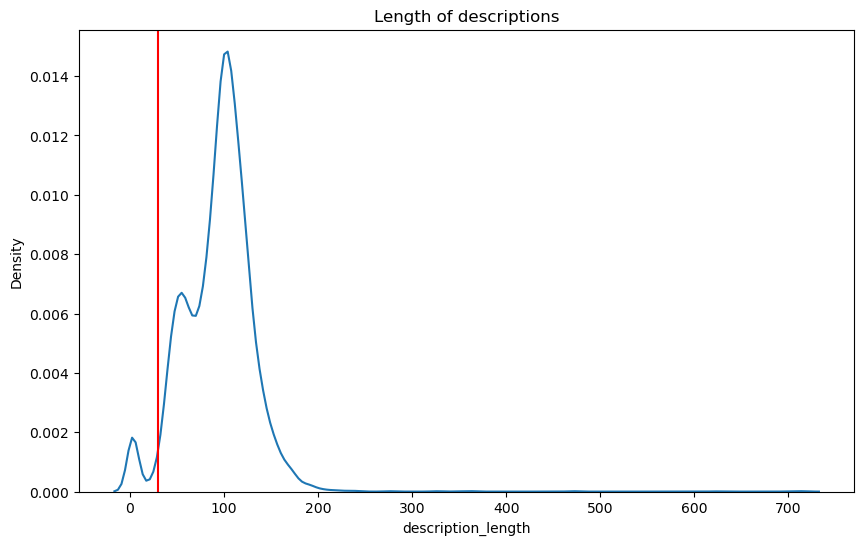

In [249]:
#plot the length of the descriptions for the products
plt.figure(figsize=(10,6))
sns.kdeplot(df_clean['description_length'])
plt.axvline(30, c='r')
plt.title('Length of descriptions')
plt.show()

### Filtering for the description word length

Get rid of the products with a description word length that are below a certain threshold of 30 words.

In [250]:
word_length_threshold = 30

df_clean = df_clean.loc[df_clean['description_length'] >= word_length_threshold]    # Get rid of the descriptions that are less than 30 words
df_clean = df_clean.loc[df_clean['category'] != 'kiosk']        # Get rid of the kiosk category as we only work with foods
df_clean.describe()

,product_id,price_amount,description_length
count,9918.000000,9918.000000,9918.000000
mean,77176.986288,140.857947,96.425187
std,34707.467602,140.231644,30.667614
min,14532.000000,0.020000,30.000000
25%,51303.000000,50.000000,76.000000
50%,81812.500000,102.565000,99.000000
75%,108703.750000,178.457500,116.000000
max,133516.000000,998.570000,325.000000


The data has been preprocessed and we extract the data that we work with:

In [251]:
df_clean.to_csv('data/df_clean_data.csv', index=False, sep=";")